In [26]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/train-dataset/train.csv
/kaggle/input/train-dataset/test.csv
/kaggle/input/submission/sample_submission.csv
/kaggle/input/model-save/Model_Save.txt
/kaggle/input/test-orig/test.csv


## Importing All Modeules that we need

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

from scipy import stats
import seaborn as sns
from copy import deepcopy

%matplotlib inline


import xgboost as xgb
import pickle
import sys
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix, hstack
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV 

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error

## Loading Data
* We loaded the data into train_data and test_data
* seperated feature names , categorical feature names and continous feature names.
* Done label encoding.
* Added a feature which is a log transformation with some shift on loss feature. Why this should be done is explained in the EDA part of the code.
* seperated x_train and y_train

In [2]:
print('Loadind data from csv files.....')
train_data = pd.read_csv('../input/train-dataset/train.csv')
test_data  = pd.read_csv('../input/test-orig/test.csv')
print('shape of train data :',train_data.shape)
print('shape of test data :',test_data.shape)


test_data['loss'] = np.nan
combined_data = pd.concat([train_data, test_data])
print('Joining complete....')
print('shape of combined data:',combined_data.shape)


categorical_features = list(train_data.select_dtypes(include = ['object']).columns)
print('Total number of categorical features in data are :', len(categorical_features))

no_common = []
for i in categorical_features:
    if train_data[i].nunique() != test_data[i].nunique():
        no_common.append(i)
print('Features that have diff unique values in train and test are :')
print(no_common)

Loadind data from csv files.....
shape of train data : (188318, 132)
shape of test data : (125546, 131)
Joining complete....
shape of combined data: (313864, 132)
Total number of categorical features in data are : 116
Features that have diff unique values in train and test are :
['cat90', 'cat92', 'cat96', 'cat99', 'cat101', 'cat102', 'cat103', 'cat105', 'cat106', 'cat109', 'cat110', 'cat113', 'cat114', 'cat116']


In [13]:
def log_xgboost_eval_mae(pred,dtrain):
    labels = dtrain.get_label()
    a = mean_absolute_error(np.exp(pred),np.exp(labels))
    return 'mae',a

def search_feature(x):
    if x in combined_remaining:
        return np.nan
    return 

#Reference https://www.geeksforgeeks.org/python-pandas-factorize/
#Reference https://stackoverflow.com/questions/13331698/how-to-apply-a-function-to-two-columns-of-pandas-dataframe

for i in categorical_features:
    if train_data[i].nunique() != test_data[i].nunique():
        train_unique_set = set(train_data[i].unique())
        test_unique_set  = set(test_data[i].unique())
        remaining_train  = train_unique_set - test_unique_set
        remaining_test   = test_unique_set - train_unique_set
        
        combined_remaining = remaining_train.union(remaining_test)
        
        combined_data[i] = combined_data[i].apply(lambda x: search_feature(x),1)
    combined_data[i] = pd.factorize(combined_data[i].values,sort = True)[0]

## How i handled categrocal features having diff unique values in train and test data
* I created an array which consists of unique values for a particual feature that are either in train or test data but not in both.
* function search_feature returns a variable if it should not be removed and returns nan if it should be removed.
* After applying search feature for a column, it returns ctegorical variables and NAN values
* after that i used pandas factorize feature which returns and replaces all categorical variables by integers and NAN by -1. 

## Making data model ready.

In [14]:
x_train = combined_data[combined_data['loss'].notnull()]
x_test = combined_data[combined_data['loss'].isnull()]

shift = 200
y_train = np.log(x_train['loss']+shift)
x_train = x_train.drop(['loss','id'],axis = 1)
x_test  = x_test.drop(['loss','id'],axis = 1)

print(x_train.shape)
print(x_test.shape)

(188318, 130)
(125546, 130)


## A function to run multiple regression models
* Why is the need to this?

* As this is a regression analysis,i wanted to apply multiple types of regression techniques that are mentioned below.
* Apply regression models without any hyperparamter tuning.
* once the models are completed , will check a score on cv dataset on which will give less error.
* Than will choose that as a primary regression model for out final model.

In [4]:
def run_models(x_train,y_train,x_cv,y_cv):
    model_xgb = XGBRegressor()
    model_adb = AdaBoostRegressor()
    model_rf  = RandomForestRegressor()
    model_gbd = GradientBoostingRegressor()
    model_knn = KNeighborsRegressor()
    model_eln = ElasticNet()
    model_las = Lasso()
    model_rid = Ridge()
    model_lr  = LinearRegression()
    model_dt  = DecisionTreeRegressor()
    
    models = [model_xgb,model_adb,model_rf,model_gbd,model_knn,model_eln,model_las,model_rid,model_lr,model_dt]
    model_dict = {}
    
    for i in models:
        model = i
        model.fit(x_train,y_train)
        pred =  model.predict(x_cv)
        a = mean_absolute_error(np.exp(y_cv), np.exp(pred))
        model_dict.update({i:a})
        
    return model_dict

## Splitting train data into train and cv data.

In [ ]:
x_train1,x_cv1,y_train1,y_cv1 = train_test_split(x_train,y_train,test_size = 0.2)
model_dict = run_models(x_train1,y_train1,x_cv1,y_cv1)

## Plotting histogram distribution of MAE values over all trained models.

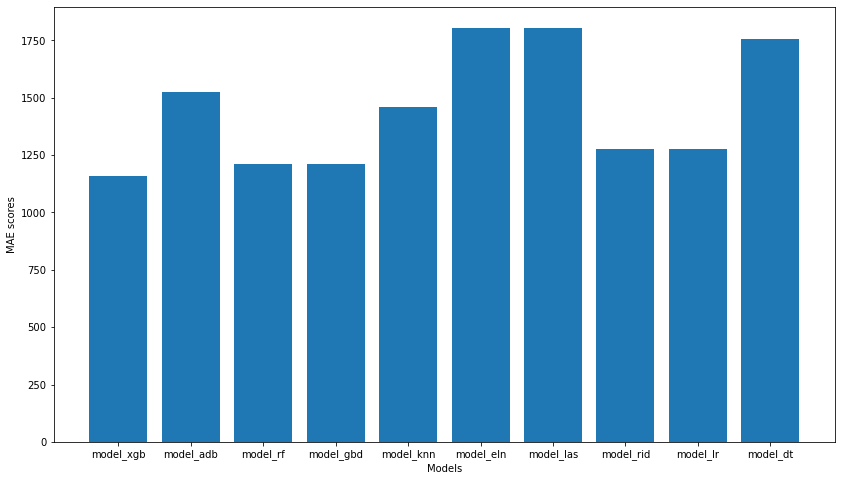

In [7]:
MAE_vales = model_dict.values()
models = ['model_xgb','model_adb','model_rf','model_gbd','model_knn','model_eln','model_las','model_rid','model_lr','model_dt']
plt.figure(figsize=(14,8))
plt.xlabel('Models')
plt.ylabel('MAE scores')
plt.bar(models,MAE_vales)
plt.show()

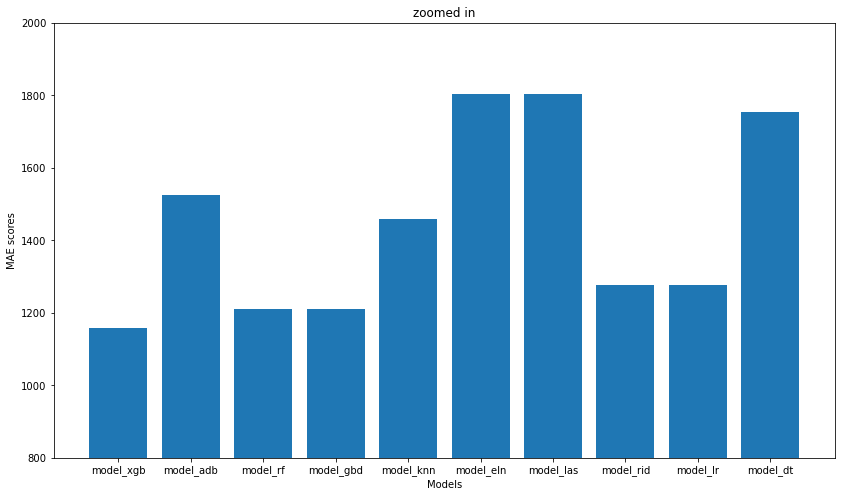

In [8]:
MAE_vales = model_dict.values()
models = ['model_xgb','model_adb','model_rf','model_gbd','model_knn','model_eln','model_las','model_rid','model_lr','model_dt']
plt.figure(figsize=(14,8))
plt.ylim(800,2000)
plt.xlabel('Models')
plt.ylabel('MAE scores')
plt.bar(models,MAE_vales)
plt.title('zoomed in')
plt.show()

In [9]:
print(MAE_vales)

dict_values([1158.820772507829, 1525.3463970284195, 1211.651647792013, 1210.795618910887, 1459.4503827092028, 1804.9400204491346, 1804.9400204491346, 1277.3354617593623, 1277.3570621381039, 1754.3839458074149])


## Observations:
* Trained different kinds of regression models without any hyperparameter tuning.
* over all diff kinds of models some models did worse than other as our data has 130 dimenstions and not all models can do well with high dimension data.
* Even without any hyper parameter tuning , XGBOOST gave the best MAE value on the cv data.
* This cross validate is only for our purpose to check the model accuracy as test data that we were given doesnt have target values.

## One Hot Encoding

In [10]:
data_ohe = pd.get_dummies(data=train_data, columns=categorical_features)
data_ohe.reset_index(drop = True, inplace = True)
print('Shape of data after OHE :',data_ohe.shape)

x_train = data_ohe.drop(['id','loss'],axis =1)
y_train = np.log(data_ohe['loss'])

x_train_ohe,x_cv_ohe,y_train_ohe,y_cv_ohe = train_test_split(x_train,y_train,test_size = 0.2)

Shape of data after OHE : (188318, 1155)


## Applying XGBRegressor on OHE features.
* Main goal here is to check which encoding works better for these kinds of features.
* we will decide based on cv MAE score on when both encodings on XGBRegressor model.

In [11]:
model = XGBRegressor()
model.fit(x_train_ohe,y_train_ohe)
pred =  model.predict(x_cv_ohe)
a = mean_absolute_error(np.exp(y_cv_ohe), np.exp(pred))
print(a)

1165.9142026607606


## Observation:
* we can see that MAE value of XGBOOSTREGRESSOR with out hyer parameter tning.
* Label encoder data  - 1158.8207
* OHE data - 1165.91420
* we can say that label encoding works better than OHE

## Hyper Parameter Tuning for XGBOOST

In [18]:
#  reference
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f

param_test1 = {
 'max_depth':range(3,15,2),
 'min_child_weight':range(1,6,2)
}
clf = XGBRegressor(learning_rate =0.01, n_estimators=140, max_depth=5,
                min_child_weight=1, gamma=0.005, subsample=0.9, colsample_bytree=0.75,
                objective= 'reg:linear', scale_pos_weight=1, seed=0, 
                param_grid = param_test1,scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1 = GridSearchCV(estimator =clf,param_grid = param_test1)
gsearch1.fit(x_train,y_train)

param_test1 = {
 'max_depth':[11,12,13),
 'min_child_weight':range(1,3)
}
clf = XGBRegressor(learning_rate =0.01, n_estimators=140, max_depth=5,
                min_child_weight=1, gamma=0.005, subsample=0.9, colsample_bytree=0.75,
                objective= 'reg:linear', scale_pos_weight=1, seed=0, 
                param_grid = param_test1,scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1 = GridSearchCV(estimator =clf,param_grid = param_test1)
gsearch1.fit(x_train,y_train)
print('Fisrt hyper parameter tune results:',gsearch1.best_params_)


param_test1 = {
 'learning_rate':[0.01,0.1,0,1],
 'gamma':[0.02,0.1,1,1.02]
}

clf = XGBRegressor(learning_rate =0.01, n_estimators=140, max_depth=5,
                min_child_weight=1, gamma=0.005, subsample=0.9, colsample_bytree=0.75,
                objective= 'reg:linear', scale_pos_weight=1, seed=0, 
                param_grid = param_test1,scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch2 = GridSearchCV(estimator =clf,param_grid = param_test1)
gsearch2.fit(x_train,y_train)
print('Second hyper parameter tune results:',gsearch2.best_params_)


param_test1 = {
 'colsample_bytree': [0.5,0.6,0.7,0.75],
 'subsample' :[0.9,0.8,0.7]
}

clf = XGBRegressor(learning_rate =0.01, n_estimators=140, max_depth=5,
                min_child_weight=1, gamma=0.005, subsample=0.9, colsample_bytree=0.75,
                objective= 'reg:linear', scale_pos_weight=1, seed=0, 
                param_grid = param_test1,scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch3 = GridSearchCV(estimator =clf,param_grid = param_test1)
gsearch3.fit(x_train,y_train)
print('Third hyper parameter tune results:',gsearch3.best_params_)

print('***** Final Hyper Parameter Tuning *****')

param_test1 = {
    'colsample_bytree': [0.4,0.5,0.6],
    'subsample': [0.8,0.9,0.7],
    'gamma': [0.015,0.01,0.1],
    'learning_rate': [0.1,0.01,0.15],
    'max_depth': [10,11,12], 
    'min_child_weight': [1,2,3]
}

clf = XGBRegressor(n_estimators=140,objective= 'reg:linear', scale_pos_weight=1, seed=0,silent =1,
                 param_grid = param_test1,scoring='roc_auc',n_jobs=4,iid=False, cv=5,num_parallel_tree = 1)

gsearch4 = GridSearchCV(estimator =clf,param_grid = param_test1)
gsearch4.fit(x_train,y_train)
print('Final hyper parameter tune results:',gsearch4.best_params_)

Fisrt hyper parameter tune results:{'max_depth': 10, 'min_child_weight': 1}
Second hyper parameter tune results:{'gamma': 1, 'learning_rate': 0.1}
Third hyper parameter tune results:{'colsample_bytree': 0.6, 'subsample': 0.8}
***** Final Hyper Parameter Tuning *****
Final hyper parameter tune results:{'colsample_bytree': 0.5,'subsample': 0.8,'learning_rate': 0.1,'max_depth': 12,'min_child_weight': 1,'gamma':1}


* We tuned 2 parameters and got {'max_depth': 10, 'min_child_weight': 1}
* We tuned 2 parameters and got {'gamma': 1, 'learning_rate': 0.1}
* We tuned 2 parameters and got {'colsample_bytree': 0.6, 'subsample': 0.8}
* Final hyper parameter tune results:{'colsample_bytree': 0.5,'subsample': 0.8,'learning_rate': 0.1,'max_depth': 12,'min_child_weight': 1,'gamma':1}

In [20]:
# Finding best rounds via cross validate xgboost with 50 early stoppings.
res = xgb.cv(params, xgtrain, num_boost_round=2500, nfold=5, stratified=False,
         early_stopping_rounds=50, verbose_eval=500, show_stdv=True, feval=log_xgboost_eval_mae, maximize=False)


[0]	train-rmse:7.26350+0.00124	test-rmse:7.26350+0.00503	train-mae:3235.56396+4.96432	test-mae:3235.56401+19.85736
[500]	train-rmse:0.46110+0.00029	test-rmse:0.48638+0.00170	train-mae:1118.87234+1.77473	test-mae:1179.87725+9.47952
[1000]	train-rmse:0.43163+0.00035	test-rmse:0.47696+0.00134	train-mae:1026.26772+1.53510	test-mae:1141.59067+7.82845
[1500]	train-rmse:0.41921+0.00039	test-rmse:0.47563+0.00126	train-mae:993.74723+1.49601	test-mae:1137.34856+7.88345
[2000]	train-rmse:0.41051+0.00038	test-rmse:0.47523+0.00120	train-mae:971.77592+1.49968	test-mae:1136.02644+7.71141


In [21]:
best_nrounds = res.shape[0] - 1
cv_mean = res.iloc[-1, 0]
cv_std = res.iloc[-1, 1]
print('Ensemble-CV: {0}+{1}'.format(cv_mean, cv_std))
print('Best n rounds are :',best_nrounds)

Ensemble-CV: 0.40487799999999996+0.0002799499955349193
Best n rounds are : 2418


## Training Final Model

In [22]:
RANDOM_STATE = 2016
params = {
        'min_child_weight': 1,
        'eta': 0.01,
        'colsample_bytree': 0.5,
        'learning_rate': 0.1,
        'max_depth': 12,
        'subsample': 0.8,
        'alpha': 1,
        'gamma': 1,
        'silent': 1,
        'verbose_eval': True,
        'seed': RANDOM_STATE
    }

xgtrain = xgb.DMatrix(x_train, label=y_train)
xgtest = xgb.DMatrix(x_test)

model = xgb.train(params, xgtrain, best_nrounds, feval=log_xgboost_eval_mae)

prediction = np.exp(model.predict(xgtest)) - shift

sub = pd.read_csv('../input/submission/sample_submission.csv')
sub['loss'] = prediction
sub.to_csv('submissions1.csv', index=False)

## Observations:
* we modelled xgb.train with best rounds we got in cross validate xgboost.
* once we predicted and converted to csv file we got a score of 1114.48304 , which is very close to leaderboard score at kaggle which is 1109.70772.
* So far this is the best model that we built.

## Feature Importance.
* importance_type
* ‘weight’ - the number of times a feature is used to split the data across all trees.
* ‘gain’ - the average gain across all splits the feature is used in.
* ‘cover’ - the average coverage across all splits the feature is used in.
* ‘total_gain’ - the total gain across all splits the feature is used in.
* ‘total_cover’ - the total coverage across all splits the feature is used in.

In [23]:
# reference - https://stackoverflow.com/questions/37627923/how-to-get-feature-importance-in-xgboost
# reference - https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value

feature_imp = model.get_score(importance_type='gain')
sorted_feature_imp = sorted(feature_imp.items(), key=lambda x: x[1],reverse=True)    
print(sorted_feature_imp)

[('cat80', 162.2719000009297), ('cat12', 87.26782582080102), ('cat79', 79.60965513514314), ('cat57', 36.22010919383452), ('cat87', 30.03140810011797), ('cat81', 29.693861800894787), ('cat10', 24.879644147797677), ('cat53', 21.933176503048287), ('cat1', 19.673499734367155), ('cat44', 17.1280969359697), ('cat38', 16.446144060439853), ('cat11', 12.372713314280027), ('cat111', 11.300631667603176), ('cat13', 11.150816345742737), ('cat72', 11.056952663214664), ('cat89', 10.472847536806889), ('cat5', 9.66238212825089), ('cat2', 9.385492227500148), ('cat26', 9.033314502639739), ('cat9', 8.8588270898421), ('cat7', 8.745802133176394), ('cat25', 7.884212813852916), ('cat52', 7.610929603415244), ('cat49', 7.506278523914056), ('cat3', 6.8633412871073425), ('cat4', 6.460700377858011), ('cat37', 6.074376528546785), ('cat36', 5.475283390459903), ('cont2', 5.330136365055739), ('cat100', 5.128326088400257), ('cat6', 4.782938554946328), ('cat76', 4.761914553074233), ('cat50', 4.716160970387901), ('cat16'

## Least important features.


In [24]:
least_imp_features = []
for i,x in enumerate(list(sorted_feature_imp)[-11:]):
    print('least important',i,'feature is ',x[0])
    least_imp_features.append(x[0])
    
print('*********')
print(least_imp_features)

least important 0 feature is  cat24
least important 1 feature is  cat60
least important 2 feature is  cat46
least important 3 feature is  cat69
least important 4 feature is  cat34
least important 5 feature is  cat47
least important 6 feature is  cat70
least important 7 feature is  cat20
least important 8 feature is  cat15
least important 9 feature is  cat64
least important 10 feature is  cat62
*********
['cat24', 'cat60', 'cat46', 'cat69', 'cat34', 'cat47', 'cat70', 'cat20', 'cat15', 'cat64', 'cat62']


## Observation:
*  we can see that 'cat24', 'cat60', 'cat46', 'cat69', 'cat34', 'cat47', 'cat70', 'cat20', 'cat15', 'cat64', 'cat62' -  these are least important features for the trined model.

## Training Basic Deep learning model.

In [25]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,BatchNormalization
from keras.layers.advanced_activations import PReLU

def neural_network_model(x_train):
    model = Sequential()
    
    model.add(Dense(400, input_dim = x_train.shape[1], init = 'he_normal'))
    model.add(PReLU())
    model.add(Dropout(0.4))
   
    model.add(Dense(200, init = 'he_normal'))
    model.add(PReLU())
    model.add(Dropout(0.2))
    
    model.add(Dense(100, init = 'he_normal'))
    model.add(PReLU())
    model.add(Dropout(0.2))
    
    model.add(Dense(50, init = 'he_normal'))
    model.add(PReLU())
    model.add(Dropout(0.2))
    
    model.add(Dense(1, init = 'he_normal'))
    model.compile(loss = 'mae', optimizer = 'adam')
    return(model)


model=neural_network_model(x_train)
n_epochs = 25
fit = model.fit(x_train,y_train, nb_epoch = n_epochs,batch_size=250,verbose = 1)
p_test = np.exp(model.predict(x_test)) - 200
sub = pd.read_csv('../input/submission/sample_submission.csv')
sub['loss'] = p_test
sub.to_csv('submissions2.csv', index=False)

Using TensorFlow backend.


Epoch 1/25
188318/188318 [==============================] - 9s 46us/step - loss: 1.1130
Epoch 2/25
188318/188318 [==============================] - 8s 43us/step - loss: 0.7692
Epoch 3/25
188318/188318 [==============================] - 8s 43us/step - loss: 0.6917
Epoch 4/25
188318/188318 [==============================] - 8s 45us/step - loss: 0.6379
Epoch 5/25
188318/188318 [==============================] - 8s 43us/step - loss: 0.5907
Epoch 6/25
188318/188318 [==============================] - 8s 43us/step - loss: 0.5595
Epoch 7/25
188318/188318 [==============================] - 8s 43us/step - loss: 0.5392
Epoch 8/25
188318/188318 [==============================] - 8s 42us/step - loss: 0.5239
Epoch 9/25
188318/188318 [==============================] - 8s 42us/step - loss: 0.5115
Epoch 10/25
188318/188318 [==============================] - 8s 43us/step - loss: 0.5001
Epoch 11/25
188318/188318 [==============================] - 8s 45us/step - loss: 0.4895
Epoch 12/25
188318/188318 [===

## Observations:
* after submitting the csv file in kaggle we got a score of 1359.49641, which is really bad considering we got a score of around 1119 using normal xgboost.
* there are multiple reasons i can think of why this neural network did bad.
1. first and foremost we have to accept the fact that not every probelm needs neural networks as a solution
1. we havent tuned our hyperparameters in neural networks, so we can increase our score after tuning our neural network,
1. there are many possible cobinations of number of neurons in each layer, droup out rate, activations that we can use....and some other parmeters.
1. we might increase our score after hyper parameter tuning